# Project Checkpoint 1: Dataset Selection & Exploratory Data Analysis

**Author:** Aiden Stickney  
**Course:** Data Mining & Analysis (CSCE 676), Spring 2026, Texas A&M University  
**Dataset:** [Reveal CPU & GPU Telemetry Dataset](https://huggingface.co/datasets/subsetchen/RevealTelemetryDatasetforMLInfraProfilingAnomalyDetection) (CC BY 4.0)  
**Github Project Repository:** [InfraScope](https://github.com/AidenStickney/InfraScope)

---

This notebook performs EDA on the Reveal Telemetry Dataset, a multivariate hardware telemetry time-series dataset collected from HPC nodes running ML workloads at 100 ms sampling intervals.

**Scope:** Both the GPU subset (~4.5 GB compressed, ~24 GB unzipped) and the CPU subset (~17 GB compressed, ~74 GB unzipped) are fully analyzed. EDA is performed on sampled files from each to assess data quality, and symbolic baskets are constructed independently for GPU and CPU telemetry.

**Goal:** Validate that this dataset supports frequent itemset mining and sequential pattern mining by constructing symbolic "baskets" from windowed telemetry and characterizing their properties.

## 0. Setup

Note: Warnings are suppressed for cleaner output.

In [44]:
import os
import warnings
import zipfile
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from itertools import combinations
import urllib.request

warnings.filterwarnings("ignore", category=FutureWarning)
sns.set_theme(style="whitegrid", font_scale=1.1)
pd.set_option("display.max_columns", 40)

PROJECT_DIR = Path(".")
DATA_DIR = PROJECT_DIR / "data"
DATA_DIR.mkdir(exist_ok=True)

assert DATA_DIR.is_dir(), f"{DATA_DIR} is not a directory."

print("Setup complete")

Setup complete


## 1. Download the Dataset

The following files are downloaded from Hugging Face:
- `meta_gpu.csv` and `meta_cpu.csv`: lightweight metadata (file paths, row/column counts, workload labels)
- `Reveal_CPU.zip`: the CPU telemetry files (17 GB Zipped, 74 GB unzipped)
- `Reveal_GPU.zip`: the GPU telemetry files (4.5 GB Zipped, 24 GB unzipped)

In [45]:
REPO_URL = "https://huggingface.co/datasets/subsetchen/RevealTelemetryDatasetforMLInfraProfilingAnomalyDetection"
REVEAL_CPU_URL = "https://huggingface.co/datasets/subsetchen/RevealTelemetryDatasetforMLInfraProfilingAnomalyDetection/resolve/main/Reveal_CPU.zip?download=true"
REVEAL_GPU_URL = "https://huggingface.co/datasets/subsetchen/RevealTelemetryDatasetforMLInfraProfilingAnomalyDetection/resolve/main/Reveal_GPU.zip?download=true"
META_CPU_URL = "https://huggingface.co/datasets/subsetchen/RevealTelemetryDatasetforMLInfraProfilingAnomalyDetection/resolve/main/meta_cpu.csv?download=true"
META_GPU_URL = "https://huggingface.co/datasets/subsetchen/RevealTelemetryDatasetforMLInfraProfilingAnomalyDetection/resolve/main/meta_gpu.csv?download=true"

# Download meta files (if not already present)
if not (DATA_DIR / "meta_cpu.csv").exists():
    try:
        print("Downloading meta_cpu.csv...")
        urllib.request.urlretrieve(META_CPU_URL, DATA_DIR / "meta_cpu.csv")
    except Exception as e:
        print(f"Failed to download meta_cpu.csv: {e}")

if not (DATA_DIR / "meta_gpu.csv").exists():
    try:
        print("Downloading meta_gpu.csv...")
        urllib.request.urlretrieve(META_GPU_URL, DATA_DIR / "meta_gpu.csv")
    except Exception as e:
        print(f"Failed to download meta_gpu.csv: {e}")

# Download telemetry files
if not (DATA_DIR / "Reveal_CPU.zip").exists() and not (DATA_DIR / "Reveal_CPU").exists():
    try:
        print("Downloading Reveal_CPU.zip...")
        urllib.request.urlretrieve(REVEAL_CPU_URL, DATA_DIR / "Reveal_CPU.zip")
    except Exception as e:
        print(f"Failed to download Reveal_CPU.zip: {e}")

if not (DATA_DIR / "Reveal_GPU.zip").exists() and not (DATA_DIR / "Reveal_GPU").exists():
    try:
        print("Downloading Reveal_GPU.zip...")
        urllib.request.urlretrieve(REVEAL_GPU_URL, DATA_DIR / "Reveal_GPU.zip")
    except Exception as e:
        print(f"Failed to download Reveal_GPU.zip: {e}")

# Unzip telemetry files (if not already unzipped)
if (DATA_DIR / "Reveal_CPU.zip").exists() and not (DATA_DIR / "Reveal_CPU").exists():
    try:
        print("Unzipping Reveal_CPU.zip...")
        with zipfile.ZipFile(DATA_DIR / "Reveal_CPU.zip", "r") as zip_ref:
            zip_ref.extractall(DATA_DIR / "Reveal_CPU")
    except Exception as e:
        print(f"Failed to unzip Reveal_CPU.zip: {e}")

if (DATA_DIR / "Reveal_GPU.zip").exists() and not (DATA_DIR / "Reveal_GPU").exists():
    try:
        print("Unzipping Reveal_GPU.zip...")
        with zipfile.ZipFile(DATA_DIR / "Reveal_GPU.zip", "r") as zip_ref:
            zip_ref.extractall(DATA_DIR / "Reveal_GPU")
    except Exception as e:
        print(f"Failed to unzip Reveal_GPU.zip: {e}")

print("Downloads complete")

assert (DATA_DIR / "meta_cpu.csv").exists(), "meta_cpu.csv is missing."
assert (DATA_DIR / "meta_gpu.csv").exists(), "meta_gpu.csv is missing."
assert (DATA_DIR / "Reveal_CPU").is_dir(), "Reveal_CPU directory is missing."
assert (DATA_DIR / "Reveal_GPU").is_dir(), "Reveal_GPU directory is missing."

cpu_infer_dirs = [DATA_DIR / "Reveal_CPU" / "infer_seperated", DATA_DIR / "Reveal_CPU" / "infer_separated"]
cpu_train_dirs = [DATA_DIR / "Reveal_CPU" / "train_seperated", DATA_DIR / "Reveal_CPU" / "train_separated"]
gpu_infer_dirs = [DATA_DIR / "Reveal_GPU" / "infer_seperated", DATA_DIR / "Reveal_GPU" / "infer_separated"]
gpu_train_dirs = [DATA_DIR / "Reveal_GPU" / "train_seperated", DATA_DIR / "Reveal_GPU" / "train_separated"]

assert any(any(d.glob("*.txt")) for d in cpu_infer_dirs if d.exists()), "No txt files found in Reveal_CPU/infer_separated."
assert any(any(d.glob("*.txt")) for d in cpu_train_dirs if d.exists()), "No txt files found in Reveal_CPU/train_separated."
assert any(any(d.glob("*.txt")) for d in gpu_infer_dirs if d.exists()), "No txt files found in Reveal_GPU/infer_separated."
assert any(any(d.glob("*.txt")) for d in gpu_train_dirs if d.exists()), "No txt files found in Reveal_GPU/train_separated."

Downloads complete


In [46]:
gpu_dir = DATA_DIR / "Reveal_GPU"
cpu_dir = DATA_DIR / "Reveal_CPU"

# List top-level contents
for dir_path in [cpu_dir, gpu_dir]:
    print(f"\nContents of {dir_path.name}:")
    for p in sorted(dir_path.iterdir()):
        if p.is_dir():
            n_files = len(list(p.glob("*.txt")))
            print(f"\t{p.name}/({n_files} .txt files)")
        elif p.is_file() and p.name == ".DS_Store":
            continue
        else:
            print(f"\t{p.name}({p.stat().st_size / 1e6:.1f} MB)")


Contents of Reveal_CPU:
	infer_separated/(1341 .txt files)
	train_separated/(1701 .txt files)

Contents of Reveal_GPU:
	infer_separated/(740 .txt files)
	train_separated/(740 .txt files)


## 2. D.1: Data Inventory & Structure

First, the meta CSVs are loaded to understand the full dataset scope across both CPU and GPU without needing all the raw files.

In [47]:
meta_cpu_path = DATA_DIR / "meta_cpu.csv"
meta_gpu_path = DATA_DIR / "meta_gpu.csv"

# Parse meta files
meta_gpu = pd.read_csv(meta_gpu_path)
meta_cpu = pd.read_csv(meta_cpu_path)

print(f"GPU meta: {len(meta_gpu)} runs, columns: {list(meta_gpu.columns)}")
print(f"CPU meta: {len(meta_cpu)} runs, columns: {list(meta_cpu.columns)}")
print(f"Total: {len(meta_gpu) + len(meta_cpu)} runs")
print("\nGPU meta sample:")
display(meta_gpu.head(3))
print("\nCPU meta sample:")
display(meta_cpu.head(3))

GPU meta: 680 runs, columns: ['source_file', 'n_rows', 'n_cols', 'phase', 'mode', 'model', 'task', 'dataset', 'model_task', 'workload']
CPU meta: 3042 runs, columns: ['source_file', 'n_rows', 'n_cols', 'phase', 'mode', 'model', 'task', 'dataset', 'model_task', 'workload']
Total: 3722 runs

GPU meta sample:


,source_file,n_rows,n_cols,phase,mode,model,task,dataset,model_task,workload
0,./train_separated/data_DEEPSEEKforTextClassifi...,17595,678,fine-tuning,llm,DEEPSEEK,TextClassification,default,DEEPSEEK__TextClassification,DEEPSEEK__TextClassification__default
1,./train_separated/data_DEEPSEEKforTextClassifi...,19203,678,fine-tuning,llm,DEEPSEEK,TextClassification,default,DEEPSEEK__TextClassification,DEEPSEEK__TextClassification__default
2,./train_separated/data_DEEPSEEKforTextClassifi...,18854,678,fine-tuning,llm,DEEPSEEK,TextClassification,default,DEEPSEEK__TextClassification,DEEPSEEK__TextClassification__default



CPU meta sample:


,source_file,n_rows,n_cols,phase,mode,model,task,dataset,model_task,workload
0,./train_separated/data_DEEPSEEKforTextClassifi...,8884,791,fine-tuning,llm,DEEPSEEK,TextClassification,default,DEEPSEEK__TextClassification,DEEPSEEK__TextClassification__default
1,./train_separated/data_DEEPSEEKforTextClassifi...,8884,791,fine-tuning,llm,DEEPSEEK,TextClassification,default,DEEPSEEK__TextClassification,DEEPSEEK__TextClassification__default
2,./train_separated/data_DEEPSEEKforTextClassifi...,8884,791,fine-tuning,llm,DEEPSEEK,TextClassification,default,DEEPSEEK__TextClassification,DEEPSEEK__TextClassification__default


### 2.1 File counts by hardware type and split

Further breakdown of file counts by workload type and hardware type is provided to understand the distribution of telemetry data across different conditions.

In [48]:
meta_gpu["hw"] = "GPU"
meta_cpu["hw"] = "CPU"
meta_all = pd.concat([meta_gpu, meta_cpu], ignore_index=True)

counts = meta_all.groupby(["hw", "phase"]).size().unstack(fill_value=0)
counts["total"] = counts.sum(axis=1)
counts.loc["total"] = counts.sum()
print("File counts by hardware type and phase:")
counts

File counts by hardware type and phase:


phase,fine-tuning,infer,train,total
hw,,,,
CPU,405,1341,1296,3042
GPU,30,340,310,680
total,435,1681,1606,3722


### 2.2 Row-count distributions

Training runs are expected to be much longer than inference runs (more epochs = more 100 ms samples). This matters for windowing, short runs produce fewer baskets.

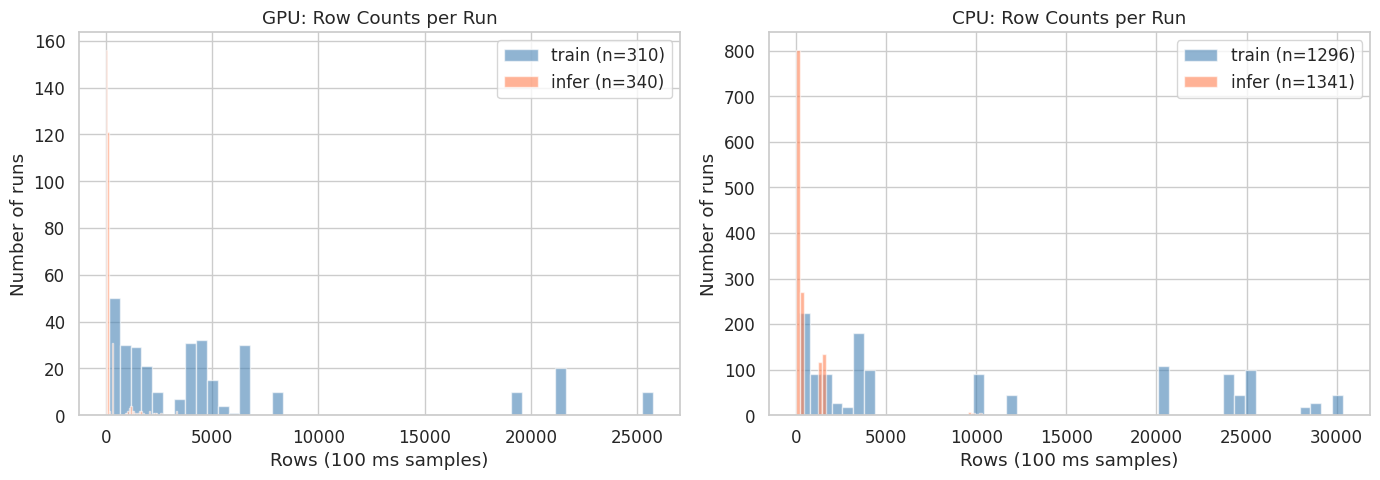


Row-count summary by hw x phase:


count     mean      std      min      25%      50%      75%  \
hw  phase                                                                       
CPU fine-tuning   405.0   7912.0    921.0   6297.0   7291.0   7884.0   8856.0   
    infer        1341.0    494.0   1215.0      5.0     34.0    148.0    277.0   
    train        1296.0  10444.0  10576.0    161.0   1400.0   3990.0  21460.0   
GPU fine-tuning    30.0  18420.0    807.0  17374.0  17674.0  18484.0  19090.0   
    infer         340.0    221.0    481.0      3.0     46.0     82.0    113.0   
    train         310.0   5489.0   6767.0    137.0   1007.0   3988.0   6328.0   

                     max  
hw  phase                 
CPU fine-tuning  10578.0  
    infer        10346.0  
    train        30353.0  
GPU fine-tuning  20000.0  
    infer         3355.0  
    train        25733.0

In [49]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=False)

for ax, hw in zip(axes, ["GPU", "CPU"]):
    subset = meta_all[meta_all["hw"] == hw]
    for phase, color in [("train", "steelblue"), ("infer", "coral")]:
        data = subset[subset["phase"] == phase]["n_rows"]
        ax.hist(data, bins=50, alpha=0.6, label=f"{phase} (n={len(data)})", color=color)
    ax.set_title(f"{hw}: Row Counts per Run")
    ax.set_xlabel("Rows (100 ms samples)")
    ax.set_ylabel("Number of runs")
    ax.legend()

plt.tight_layout()
plt.show()

# Summary statistics
print("\nRow-count summary by hw x phase:")
meta_all.groupby(["hw", "phase"])["n_rows"].describe().round(0)

### 2.3 Schema consistency (column counts)

GPU files should share a single schema. CPU files should have two dominant schemas, outliers may exist. This matters for feature selection and basket construction.

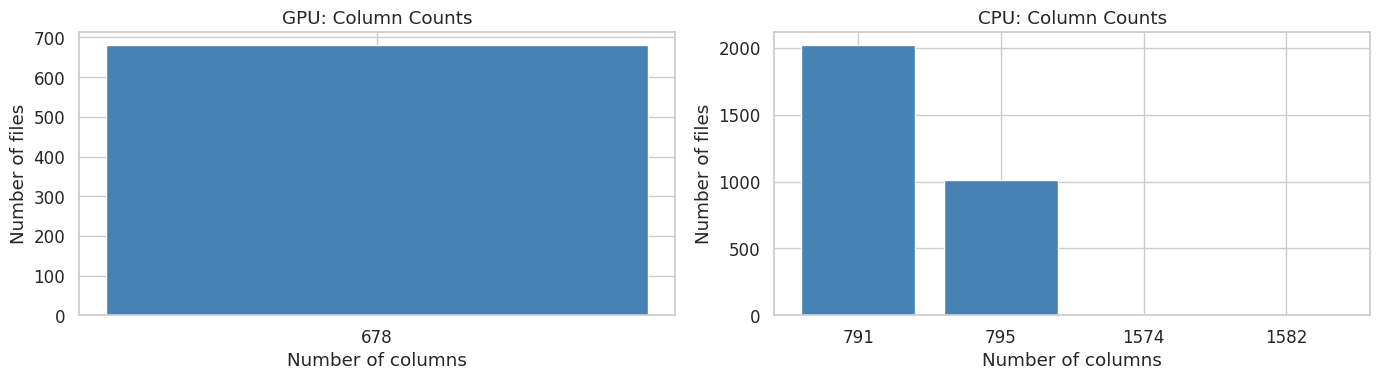


GPU n_cols values:
n_cols
678    680
Name: count, dtype: int64

CPU n_cols values:
n_cols
791     2020
795     1011
1574       8
1582       3
Name: count, dtype: int64


In [50]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

for ax, hw in zip(axes, ["GPU", "CPU"]):
    data = meta_all[meta_all["hw"] == hw]["n_cols"]
    vc = data.value_counts().sort_index()
    ax.bar(vc.index.astype(str), vc.values, color="steelblue")
    ax.set_title(f"{hw}: Column Counts")
    ax.set_xlabel("Number of columns")
    ax.set_ylabel("Number of files")

plt.tight_layout()
plt.show()

print("\nGPU n_cols values:")
print(meta_gpu["n_cols"].value_counts())
print("\nCPU n_cols values:")
print(meta_cpu["n_cols"].value_counts())

### 2.4 Workload distribution

To see what models/tasks are represented, for interpreting cross-workload comparisons later.

In [51]:
# Workload breakdown: GPU
print("GPU Runs per model_task (top 15):")
print(meta_gpu["model_task"].value_counts().head(15).to_string())
print(f"\nGPU Runs per phase x mode:")
print(meta_gpu.groupby(["phase", "mode"]).size().unstack(fill_value=0))

# Workload breakdown: CPU
print("\n\nCPU Runs per model_task (top 15):")
print(meta_cpu["model_task"].value_counts().head(15).to_string())
print(f"\nCPU Runs per phase x mode:")
print(meta_cpu.groupby(["phase", "mode"]).size().unstack(fill_value=0))

GPU Runs per model_task (top 15):
model_task
Resnet18__ImageClassification        60
Resnet50__ImageClassification        60
VGG16__ImageClassification           60
VGG19__ImageClassification           60
ViTB16__ImageClassification          60
ViTL16__ImageClassification          60
DEEPSEEK__TextClassification         20
LLAMA__TextClassification            20
MISTRAL__TextClassification          20
BARTBASE__TableQuestionAnswering     20
BARTBASE__TextClassification         20
BARTLARGE__TableQuestionAnswering    20
BARTLARGE__TextClassification        20
BERTBASE__TextClassification         20
BERTLARGE__TextClassification        20

GPU Runs per phase x mode:
mode         llm  nonllm
phase                   
fine-tuning   30       0
infer         30     310
train          0     310


CPU Runs per model_task (top 15):
model_task
DEEPSEEK__TextClassification           369
VGG16__ImageClassification             324
LLAMA__TextClassification              306
Resnet18__ImageClassificat

## 3. D.2: Data Quality, Cleaning Decisions & Justification

A representative sample is loaded of both GPU and CPU data to actually analyze:
1. Per-metric missingness
2. Structural zeros (always-zero counters)
3. Near-constant metrics (system constants)
4. Index artifacts (Unnamed: 0)

**Why sample instead of loading all files?** Loading all 1,480 GPU & 3,042 CPU files at once is very memory-intensive. Therefore sampling roughly 20 files from each gives a reliable quality profile.

In [52]:
all_gpu_files = sorted(gpu_dir.rglob("*.txt"))
all_cpu_files = sorted(cpu_dir.rglob("*.txt"))
print(f"Found {len(all_gpu_files)} GPU telemetry files")
print(f"Found {len(all_cpu_files)} CPU telemetry files")

rng = np.random.default_rng(42)
N_SAMPLE = 10 # this is per ML split and per hardware type


def sample_files(file_list: list[Path], n: int = N_SAMPLE) -> list[Path]:
    train = [f for f in file_list if "train" in f.parent.name.lower() or "fine" in f.name.lower()]
    infer = [f for f in file_list if "infer" in f.parent.name.lower() or ("data_" in f.name.lower() and "infer" in f.parent.name.lower())]
    sampled_train = list(rng.choice(train, size=min(n, len(train)), replace=False))
    sampled_infer = list(rng.choice(infer, size=min(n, len(infer)), replace=False))
    return sampled_train + sampled_infer

gpu_sample_files = sample_files(all_gpu_files)
cpu_sample_files = sample_files(all_cpu_files)

print(f"\nGPU sample: {len(gpu_sample_files)} files")
print(f"CPU sample: {len(cpu_sample_files)} files")

Found 1480 GPU telemetry files
Found 3042 CPU telemetry files

GPU sample: 20 files
CPU sample: 20 files


In [53]:
def load_sample_files(file_list: list[Path]) -> dict[str, pd.DataFrame]:
    dfs = {}
    for fpath in file_list:
        try:
            df = pd.read_csv(fpath, sep="\t")
            if df.shape[1] < 5:
                df = pd.read_csv(fpath)
            dfs[fpath.name] = df
        except Exception as e:
            print(f"\tError loading {fpath.name}: {e}")
    return dfs


sample_gpu_dfs = load_sample_files(gpu_sample_files)
sample_cpu_dfs = load_sample_files(cpu_sample_files)

print(f"GPU: loaded {len(sample_gpu_dfs)} files")
gpu_first = list(sample_gpu_dfs.keys())[0]
print(f"\tExample: {gpu_first}, shape {sample_gpu_dfs[gpu_first].shape}")

print(f"\nCPU: loaded {len(sample_cpu_dfs)} files")
cpu_first = list(sample_cpu_dfs.keys())[0]
print(f"\tExample: {cpu_first}, shape {sample_cpu_dfs[cpu_first].shape}")
print("\nSample GPU DataFrame head:")
display(sample_gpu_dfs[gpu_first].head(2))

print("\nSample CPU DataFrame head:")
display(sample_cpu_dfs[cpu_first].head(2))

GPU: loaded 20 files
	Example: train_BARTBASEforTableQuestionAnswering_default_2025-04-26T13-38-18_htc-g004.txt, shape (1615, 765)

CPU: loaded 20 files
	Example: train_VGG16forImageClassification_CIFAR10_2025-05-11T12-27-13_nserver07.txt, shape (20580, 792)

Sample GPU DataFrame head:


,Unnamed: 0,Perf:Branches.htc-g004[count],Perf:Branch_Misses.htc-g004[count],Perf:Cache_Misses.htc-g004[count],Perf:Cache_References.htc-g004[count],Perf:Cycles.htc-g004[count],Perf:Instructions.htc-g004[count],Perf:Cycle_activity_cycles_l3_miss.htc-g004[count],Perf:Cycle_activity_stalls_l3_miss.htc-g004[count],Perf:Hle_retired_aborted.htc-g004[count],Perf:Hle_retired_commit.htc-g004[count],Perf:Mem_trans_retired_load_latency_gt_128.htc-g004[count],Perf:Mem_trans_retired_load_latency_gt_256.htc-g004[count],Perf:Mem-loads.htc-g004[count],Perf:Mem-stores.htc-g004[count],Perf:IPC.htc-g004[-],Perf:BranchUtilization.htc-g004[%],Perf:CacheUtilization.htc-g004[%],Perf:StallRatio.htc-g004[%],Perf:OccupancyRatio.htc-g004[%],...,NetworkInterStat_diff:tx_errs.ib0.htc-g004[count],NetworkInterStat_diff:tx_drop.ib0.htc-g004[count],NetworkInterStat_diff:tx_fifo.ib0.htc-g004[count],NetworkInterStat_diff:tx_colls.ib0.htc-g004[count],NetworkInterStat_diff:tx_carrier.ib0.htc-g004[count],NetworkInterStat_diff:tx_compressed.ib0.htc-g004[count],NetworkInterStat_diff:NetworkUtilization.ens1f0.htc-g004[%],NetworkInterStat_diff:NetworkUtilization.ib0.htc-g004[%],NetworkProtocolCounts:TCP.htc-g004[count],NetworkProtocolCounts:UDP.htc-g004[count],NetworkProtocolCounts:UNIX.htc-g004[count],NetworkProtocolCounts:RAW.htc-g004[count],NetworkProtocolCounts:DCCP.htc-g004[count],NetworkProtocolCounts:SCTP.htc-g004[count],NetworkProtocolCounts:local_to.htc-g004[count],NetworkProtocolCounts:to_local.htc-g004[count],NetworkProtocolCounts:total_connections.htc-g004[count],NetworkTCPRetrans_diff:TcpRetransSegs.htc-g004[count],NetworkTCPRetrans_diff:TcpExtTCPSynRetrans.htc-g004[count],NetworkTCPRetrans_diff:TcpExtTCPLostRetransmit.htc-g004[count]
0,2025-04-26 13:38:18.600,270733030.0,2264396.0,816929.0,5164776.0,1.331031e+09,1.308219e+09,44904716.0,38960021.0,0.0,0.0,0.0,0.0,0.0,214276052.0,98.286144,0.836394,15.817317,2.927057,3.373680,...,0.0,0.0,0.0,0.0,0.0,0.0,0.752308,1.285881,85.0,18.0,315.0,2.0,0.0,0.0,1.0,1.0,2.0,0.0,0.0,0.0
1,2025-04-26 13:38:18.700,397947366.0,3467222.0,8248154.0,19353563.0,2.032981e+09,1.910349e+09,311985532.0,289569853.0,0.0,0.0,0.0,0.0,0.0,302005064.0,93.967886,0.871277,42.618271,14.243607,15.346209,...,0.0,0.0,0.0,0.0,0.0,0.0,1.488093,2.571761,85.0,18.0,315.0,2.0,0.0,0.0,1.0,1.0,2.0,0.0,0.0,0.0



Sample CPU DataFrame head:


,Unnamed: 0,Perf:Branches.nserver07[count],Perf:Branch_Misses.nserver07[count],Perf:Cache_Misses.nserver07[count],Perf:Cache_References.nserver07[count],Perf:Cycles.nserver07[count],Perf:Instructions.nserver07[count],Perf:Ls_dc_accesses.nserver07[count],Perf:Ls_dispatch_store_dispatch.nserver07[count],Perf:Ls_dispatch_ld_dispatch.nserver07[count],Perf:IPC.nserver07[-],Perf:BranchUtilization.nserver07[%],Perf:CacheUtilization.nserver07[%],Memory:CommitLimit.nserver07[kB],Memory:DirectMap1G.nserver07[kB],Memory:DirectMap2M.nserver07[kB],Memory:DirectMap4k.nserver07[kB],Memory:Hugepagesize.nserver07[kB],Memory:MemTotal.nserver07[kB],Memory:SwapTotal.nserver07[kB],...,NetworkInterStat_diff:tx_packets.enp1s0f0np0.nserver07[count],NetworkInterStat_diff:tx_errs.enp1s0f0np0.nserver07[count],NetworkInterStat_diff:tx_drop.enp1s0f0np0.nserver07[count],NetworkInterStat_diff:tx_fifo.enp1s0f0np0.nserver07[count],NetworkInterStat_diff:tx_colls.enp1s0f0np0.nserver07[count],NetworkInterStat_diff:tx_carrier.enp1s0f0np0.nserver07[count],NetworkInterStat_diff:tx_compressed.enp1s0f0np0.nserver07[count],NetworkInterStat_diff:NetworkUtilization.enp1s0f0np0.nserver07[%],NetworkProtocolCounts:TCP.nserver07[count],NetworkProtocolCounts:UDP.nserver07[count],NetworkProtocolCounts:UNIX.nserver07[count],NetworkProtocolCounts:RAW.nserver07[count],NetworkProtocolCounts:DCCP.nserver07[count],NetworkProtocolCounts:SCTP.nserver07[count],NetworkProtocolCounts:local_to.nserver07[count],NetworkProtocolCounts:to_local.nserver07[count],NetworkProtocolCounts:total_connections.nserver07[count],NetworkTCPRetrans_diff:TcpRetransSegs.nserver07[count],NetworkTCPRetrans_diff:TcpExtTCPSynRetrans.nserver07[count],NetworkTCPRetrans_diff:TcpExtTCPLostRetransmit.nserver07[count]
0,2025-05-11 12:27:13.100,125104049.0,11540763.0,9340163.0,42407745.0,8.593123e+08,709703375.0,302164879.0,133609508.0,203781902.0,0.825897,9.224932,22.024663,139227280.0,124780544.0,142774272.0,1793444.0,2048.0,263774508.0,8388604.0,...,1542.0,0.0,0.0,0.0,0.0,0.0,0.0,1.310932,1115.0,2.0,145.0,1.0,0.0,0.0,111.0,1101.0,1212.0,0.0,0.0,0.0
1,2025-05-11 12:27:13.200,92890094.0,9727883.0,11910599.0,62432028.0,1.382378e+09,774183446.0,300769774.0,111285290.0,126020233.0,0.560037,10.472465,19.077706,139227280.0,124780544.0,142774272.0,1793444.0,2048.0,263774508.0,8388604.0,...,3107.0,0.0,0.0,0.0,0.0,0.0,0.0,2.610174,1115.0,2.0,145.0,1.0,0.0,0.0,111.0,1101.0,1212.0,0.0,0.0,0.0


### 3.1 Index artifact detection

Some files may include an 'Unnamed: 0' column from a prior to_csv() call with index=True. This is an artifact that should be dropped, as it does not represent actual telemetry data.

In [54]:
# Check for 'Unnamed: 0' artifact
for label, dfs in [("GPU", sample_gpu_dfs), ("CPU", sample_cpu_dfs)]:
    has_unnamed = {name: "Unnamed: 0" in df.columns for name, df in dfs.items()}
    n_with = sum(has_unnamed.values())
    print(f"{label}: {n_with}/{len(has_unnamed)} sampled files have 'Unnamed: 0' column")

# Drop it from all sample frames
for dfs in [sample_gpu_dfs, sample_cpu_dfs]:
    for name in dfs:
        if "Unnamed: 0" in dfs[name].columns:
            dfs[name] = dfs[name].drop(columns=["Unnamed: 0"])

print("Dropped 'Unnamed: 0' where present")

GPU: 20/20 sampled files have 'Unnamed: 0' column
CPU: 20/20 sampled files have 'Unnamed: 0' column
Dropped 'Unnamed: 0' where present


### 3.2 Per-metric missingness

The fraction of NaN values per column across all sampled files for each hardware type is computed. Metrics that are 100% missing in every file are therefore excluded.

A heatmap of missingness across metrics and files is also generated to visually identify patterns of missing data.

In [55]:
def compute_missingness(dfs: dict[str, pd.DataFrame]) -> pd.Series:
    records = []
    for name, df in dfs.items():
        miss_frac = df.isnull().mean()
        for col, frac in miss_frac.items():
            records.append({"file": name, "metric": col, "miss_frac": frac})
    miss_df = pd.DataFrame(records)
    return miss_df.groupby("metric")["miss_frac"].mean().sort_values(ascending=False)


# GPU
avg_miss_gpu = compute_missingness(sample_gpu_dfs)
always_missing_gpu = avg_miss_gpu[avg_miss_gpu >= 1.0]
partial_miss_gpu = avg_miss_gpu[(avg_miss_gpu > 0) & (avg_miss_gpu < 1.0)]

print("GPU:")
print(f"\tMetrics 100% NaN: {len(always_missing_gpu)}")
if len(always_missing_gpu) > 0:
    for metric, frac in always_missing_gpu.head(10).items():
        print(f"\t\t{metric}: {frac:.2f}")
print(f"\tMetrics with partial missingness: {len(partial_miss_gpu)}")

# CPU
avg_miss_cpu = compute_missingness(sample_cpu_dfs)
always_missing_cpu = avg_miss_cpu[avg_miss_cpu >= 1.0]
partial_miss_cpu = avg_miss_cpu[(avg_miss_cpu > 0) & (avg_miss_cpu < 1.0)]

print(f"\nCPU:")
print(f"\tMetrics 100% NaN: {len(always_missing_cpu)}")
if len(always_missing_cpu) > 0:
    for metric, frac in always_missing_cpu.head(10).items():
        print(f"\t\t{metric}: {frac:.2f}")
print(f"\tMetrics with partial missingness: {len(partial_miss_cpu)}")
if len(partial_miss_cpu) > 0:
    print("\tMetrics with partial missingness (top 10):")
    for metric, frac in partial_miss_cpu.head(10).items():
        print(f"\t\t{metric}: {frac:.2f}")

GPU:
	Metrics 100% NaN: 16
		GPU: utilization.ofa.1.htc-g003[%]: 1.00
		GPU: utilization.ofa.0.htc-g004[%]: 1.00
		GPU: utilization.ofa.0.htc-g003[%]: 1.00
		GPU: utilization.jpeg.1.htc-g004[%]: 1.00
		GPU: utilization.jpeg.1.htc-g003[%]: 1.00
		GPU: utilization.jpeg.0.htc-g004[%]: 1.00
		GPU: utilization.jpeg.0.htc-g003[%]: 1.00
		GPU: fan.speed.0.htc-g003[%]: 1.00
		GPU: fan.speed.0.htc-g004[%]: 1.00
		GPU: utilization.ofa.1.htc-g004[%]: 1.00
	Metrics with partial missingness: 0

CPU:
	Metrics 100% NaN: 200
		Turbostat:CorWatt.25.nserver13[W]: 1.00
		Turbostat:CorWatt.25.nserver15[W]: 1.00
		Turbostat:CorWatt.25.nserver16[W]: 1.00
		Turbostat:CorWatt.26.nserver07[W]: 1.00
		Turbostat:CorWatt.26.nserver08[W]: 1.00
		Turbostat:CorWatt.26.nserver09[W]: 1.00
		Turbostat:CorWatt.26.nserver11[W]: 1.00
		Turbostat:CorWatt.26.nserver12[W]: 1.00
		Turbostat:CorWatt.26.nserver13[W]: 1.00
		Turbostat:CorWatt.26.nserver15[W]: 1.00
	Metrics with partial missingness: 9
	Metrics with partial missin

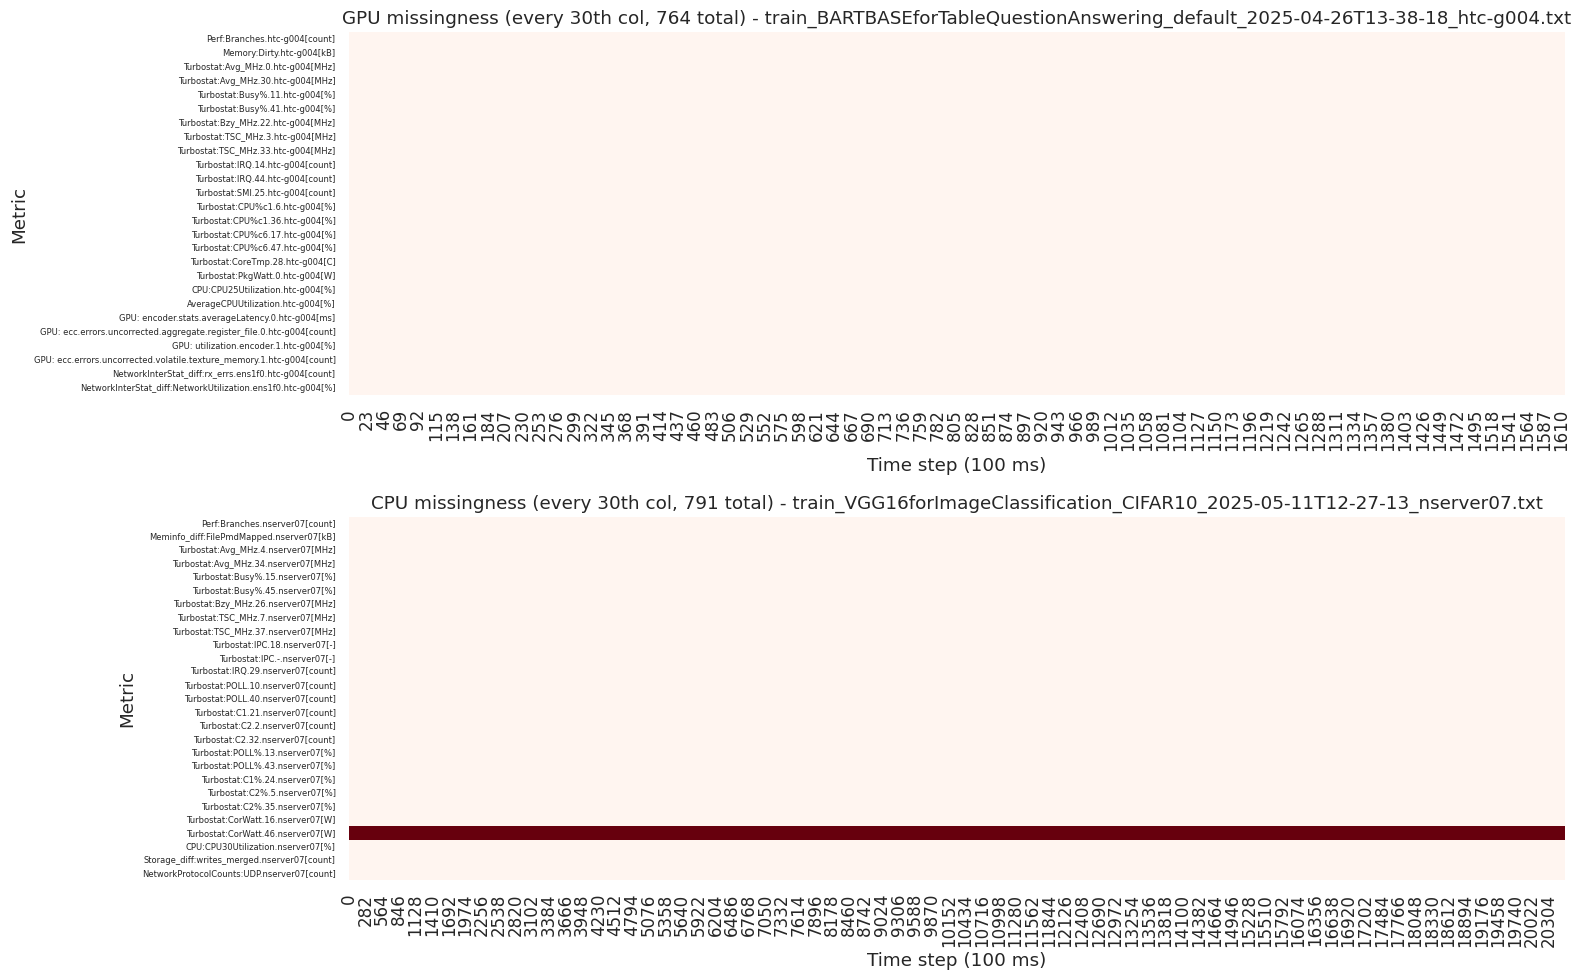

In [56]:
# Missingness heatmap
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

for ax, (label, dfs) in zip(axes, [("GPU", sample_gpu_dfs), ("CPU", sample_cpu_dfs)]):
    example_name = list(dfs.keys())[0]
    example_df = dfs[example_name]
    cols_sub = example_df.columns[::30] # every 30th col for readability
    sns.heatmap(example_df[cols_sub].isnull().T, cbar=False, yticklabels=True, ax=ax, cmap="Reds")
    ax.set_title(f"{label} missingness (every 30th col, {len(example_df.columns)} total) - {example_name}")
    ax.set_xlabel("Time step (100 ms)")
    ax.set_ylabel("Metric")
    ax.tick_params(axis="y", labelsize=6)

plt.tight_layout()
plt.show()

### 3.3 Structural zeros (always-zero metrics)

Many network error/protocol counters are expected to be zero under normal operation. Including them in itemset mining would produce trivial rules like 'tx_errs=0 -> rx_errs=0'.

**Decision:** Exclude metrics that are 100% zero across all sampled files.

In [57]:
from collections import Counter

def find_always_zero(dfs: dict[str, pd.DataFrame]) -> list[str]:
    records = []
    for name, df in dfs.items():
        numeric = df.select_dtypes(include=[np.number])
        is_all_zero = (numeric == 0).all() | numeric.isnull().all()
        for col in numeric.columns:
            records.append({"file": name, "metric": col, "all_zero": is_all_zero[col]})
    zero_df = pd.DataFrame(records)
    zero_rate = zero_df.groupby("metric")["all_zero"].mean()
    return zero_rate[zero_rate >= 1.0].index.tolist()

always_zero_gpu = find_always_zero(sample_gpu_dfs)
always_zero_cpu = find_always_zero(sample_cpu_dfs)

for label, az in [("GPU", always_zero_gpu), ("CPU", always_zero_cpu)]:
    print(f"\n{label}: {len(az)} always-zero metrics")
    prefix_counts = Counter(m.split(":")[0] if ":" in m else m.split(".")[0] for m in az)
    for prefix, count in prefix_counts.most_common(10):
        print(f"\t{prefix}: {count}")


GPU: 516 always-zero metrics
	Turbostat: 220
	GPU: 204
	NetworkInterStat_diff: 44
	Memory: 18
	Storage: 16
	Perf: 10
	NetworkProtocolCounts: 4

CPU: 720 always-zero metrics
	Turbostat: 335
	Meminfo_diff: 138
	Storage_diff: 108
	NetworkInterStat_diff: 89
	CPU: 21
	NetworkProtocolCounts: 16
	NetworkTCPRetrans_diff: 13


### 3.4 Near-constant metrics

System constants (e.g., `MemTotal`, `CommitLimit`, `VmallocTotal`) have near-zero variance across time. They provide no discriminative signal for itemset mining.

**Decision:** Flag metrics whose coefficient of variation (CV) is < 0.01 across all sampled files. Retain for context but exclude from basket construction.

**Why CV < 0.01?** A CV of 0.01 means the standard deviation is less than 1% of the mean, so the metric is effectively constant across all time steps and runs. Discretizing such a metric into terciles would produce arbitrary bin boundaries dominated by floating-point noise rather than meaningful state changes. The threshold is deliberately conservative meaning any metric excluded at 0.01 genuinely carries no useful variation for pattern mining.

In [58]:
def find_near_constant(dfs: dict[str, pd.DataFrame], cv_threshold: float = 0.01) -> pd.Series:
    records = []
    for name, df in dfs.items():
        numeric = df.select_dtypes(include=[np.number])
        means = numeric.mean()
        stds = numeric.std()
        cv = (stds / means.replace(0, np.nan)).fillna(0)
        for col in numeric.columns:
            records.append({"file": name, "metric": col, "cv": max(cv[col], 0)})
    cv_df = pd.DataFrame(records)
    avg_cv = cv_df.groupby("metric")["cv"].mean()
    return avg_cv[avg_cv < cv_threshold].sort_values()


near_constant_gpu = find_near_constant(sample_gpu_dfs)
near_constant_cpu = find_near_constant(sample_cpu_dfs)

print(f"GPU near-constant metrics (CV < 0.01): {len(near_constant_gpu)}")
for metric, cv in near_constant_gpu.head(15).items():
    print(f"\t{metric}: CV={cv:.4f}")

print(f"\nCPU near-constant metrics (CV < 0.01): {len(near_constant_cpu)}")
for metric, cv in near_constant_cpu.head(15).items():
    print(f"\t{metric}: CV={cv:.4f}")

GPU near-constant metrics (CV < 0.01): 807
	Turbostat:SMI.34.htc-g003[count]: CV=0.0000
	Storage:time_spent_discarding.htc-g003[ms]: CV=0.0000
	Storage:time_spent_discarding.htc-g004[ms]: CV=0.0000
	Storage:time_spent_reading_(ms).htc-g003[ms]: CV=0.0000
	Storage:time_spent_reading_(ms).htc-g004[ms]: CV=0.0000
	Turbostat:SMI.36.htc-g003[count]: CV=0.0000
	Turbostat:SMI.35.htc-g004[count]: CV=0.0000
	Turbostat:SMI.35.htc-g003[count]: CV=0.0000
	Turbostat:SMI.34.htc-g004[count]: CV=0.0000
	Storage:sectors_read.htc-g004[sectors]: CV=0.0000
	Turbostat:SMI.33.htc-g004[count]: CV=0.0000
	Turbostat:SMI.33.htc-g003[count]: CV=0.0000
	Turbostat:SMI.32.htc-g004[count]: CV=0.0000
	GPU: ecc.errors.corrected.volatile.dram.0.htc-g003[count]: CV=0.0000
	Turbostat:SMI.32.htc-g003[count]: CV=0.0000

CPU near-constant metrics (CV < 0.01): 1803
	Turbostat:IRQ.17.nserver08[count]: CV=0.0000
	Turbostat:IRQ.19.nserver11[count]: CV=0.0000
	Turbostat:IRQ.19.nserver09[count]: CV=0.0000
	Turbostat:IRQ.18.nserve

### 3.5 Cleaning summary & curated metric selection

Based on the analysis above, the cleaning pipeline is defined and a curated set of metrics is selected for downstream basket construction. This includes dropping index artifacts, excluding unsupported sensors (100% missing), excluding always-zero metrics, and flagging near-constant metrics.

**Why these specific metric groups?** The goal of the project is to discover cross-layer bottleneck interactions during ML workloads. The curated groups are chosen to cover the four major hardware subsystems that interact during training/inference: Compute (CPU busy%, IPC, stall ratio; GPU utilization), Memory (utilization, available), Network (rx/tx bytes), and Thermal/Power (GPU temperature, power draw). These are the subsystems most likely to exhibit coupled bottleneck behavior (e.g., a CPU stall may coincide with a memory spike, or a GPU utilization burst may drive a power/thermal increase). Disk I/O and per-core breakdowns were excluded because disk metrics were predominantly zero in the sampled files and per-core metrics would explode the item space without adding cross-layer signal.

In [59]:
# Build exclusion sets for GPU and CPU separately
def build_exclusions(always_missing: pd.Series, always_zero: list[str], near_constant: pd.Series) -> set[str]:
    excl_miss = set(always_missing.index.tolist()) if len(always_missing) > 0 else set()
    excl_zero = set(always_zero)
    excl_const = set(near_constant.index.tolist())
    return excl_miss | excl_zero | excl_const


excluded_gpu = build_exclusions(always_missing_gpu, always_zero_gpu, near_constant_gpu)
excluded_cpu = build_exclusions(always_missing_cpu, always_zero_cpu, near_constant_cpu)

for label, excluded, dfs in [("GPU", excluded_gpu, sample_gpu_dfs), ("CPU", excluded_cpu, sample_cpu_dfs)]:
    example_cols = set(list(dfs.values())[0].columns)
    usable = example_cols - excluded
    print(f"\n{label}:")
    print(f"\tTotal metrics excluded: {len(excluded)}")
    print(f"\tUsable after exclusions: {len(usable)}/{len(example_cols)}")


GPU:
	Total metrics excluded: 807
	Usable after exclusions: 357/764

CPU:
	Total metrics excluded: 1803
	Usable after exclusions: 656/791


In [60]:
import re

METRIC_GROUP_PATTERNS: dict[str, re.Pattern] = {
    # GPU subsystem (only in GPU files)
    "GPU_util": re.compile(r"utilization\.gpu\.\d+\.", re.I),
    "GPU_mem_util": re.compile(r"utilization\.memory\.\d+\.", re.I),
    "GPU_power": re.compile(r"power\.draw\.\d+\.", re.I),
    "GPU_temp": re.compile(r"temperature\.gpu\.\d+\.", re.I),
    # CPU subsystem (the ".-." token means all cores)
    "CPU_busy": re.compile(r"Turbostat:Busy%\.\-\.", re.I),
    # IPC match per host not core
    "CPU_ipc": re.compile(r"Perf:IPC\.[A-Za-z]", re.I),
    # Stall ratio
    "CPU_stall": re.compile(r"Perf:StallRatio\.", re.I),
    # Memory subsystem, CPU and GPU
    "Mem_util": re.compile(r"Memory:MemoryUtilization\.", re.I),
    # MemAvailable: GPU uses "Memory:MemAvailable" and CPU uses "Meminfo_diff:MemAvailable"
    "Mem_available": re.compile(r"MemAvailable\.", re.I),
    # Network
    "Net_rx_bytes": re.compile(r"rx_bytes\.", re.I),
    "Net_tx_bytes": re.compile(r"tx_bytes\.", re.I),
}


def select_curated_metrics(columns: list[str], excluded: set[str] | None = None) -> dict[str, list[str]]:
    if excluded is None:
        excluded = set()
    groups: dict[str, list[str]] = {}
    for group, pattern in METRIC_GROUP_PATTERNS.items():
        matched = [c for c in columns if pattern.search(c) and c not in excluded]
        if matched:
            groups[group] = matched
    return groups


# Build curated groups for GPU and CPU independently, filtering out excluded metrics at selection time
curated_gpu = select_curated_metrics(list(sample_gpu_dfs[gpu_first].columns), excluded=excluded_gpu)
curated_cpu = select_curated_metrics(list(sample_cpu_dfs[cpu_first].columns), excluded=excluded_cpu)

for label, curated in [("GPU", curated_gpu), ("CPU", curated_cpu)]:
    total = sum(len(v) for v in curated.values())
    print(f"\n{label} curated metric groups ({total} total)")
    for group, cols in curated.items():
        print(f"\t{group}: {len(cols)} metrics")
        if len(cols) <= 5:
            for c in cols:
                print(f"\t\t{c}")


GPU curated metric groups (15 total)
	GPU_util: 2 metrics
		GPU: utilization.gpu.0.htc-g004[%]
		GPU: utilization.gpu.1.htc-g004[%]
	GPU_mem_util: 2 metrics
		GPU: utilization.memory.0.htc-g004[%]
		GPU: utilization.memory.1.htc-g004[%]
	GPU_power: 2 metrics
		GPU: power.draw.0.htc-g004[W]
		GPU: power.draw.1.htc-g004[W]
	GPU_temp: 2 metrics
		GPU: temperature.gpu.0.htc-g004[C]
		GPU: temperature.gpu.1.htc-g004[C]
	CPU_busy: 1 metrics
		Turbostat:Busy%.-.htc-g004[%]
	CPU_ipc: 1 metrics
		Perf:IPC.htc-g004[-]
	CPU_stall: 1 metrics
		Perf:StallRatio.htc-g004[%]
	Net_rx_bytes: 2 metrics
		NetworkInterStat_diff:rx_bytes.ens1f0.htc-g004[Bytes]
		NetworkInterStat_diff:rx_bytes.ib0.htc-g004[Bytes]
	Net_tx_bytes: 2 metrics
		NetworkInterStat_diff:tx_bytes.ens1f0.htc-g004[Bytes]
		NetworkInterStat_diff:tx_bytes.ib0.htc-g004[Bytes]

CPU curated metric groups (6 total)
	CPU_busy: 1 metrics
		Turbostat:Busy%.-.nserver07[%]
	CPU_ipc: 1 metrics
		Perf:IPC.nserver07[-]
	Mem_util: 1 metrics
		Memory:

## 4. D.3: Windowing & Symbolic Basket Construction

Each run is segmented into fixed-length windows. 

At 100 ms sampling:
- 1s window = 10 rows
- 2s window = 20 rows
- 5s window = 50 rows

Within each window, curated metrics are aggregated (median) and discretized into symbolic states using quantile-based thresholds (terciles -> LOW, MED, and HIGH).

**Why median?** Robust to outlier spikes within a window.  
**Why terciles?** Simple, interpretable, and does not assume normality.

In [61]:
def resolve_group_columns(curated_groups: dict[str, list[str]], file_columns: list[str]) -> dict[str, list[str]]:
    resolved: dict[str, list[str]] = {}
    file_col_set = set(file_columns)
    for group, curated_cols in curated_groups.items():
        # Try exact match first
        exact = [c for c in curated_cols if c in file_col_set]
        if exact:
            resolved[group] = exact
            continue
        # Fall back is regex match to handle hostname differences
        pat = METRIC_GROUP_PATTERNS.get(group)
        if pat is not None:
            matched = [c for c in file_columns if pat.search(c)]
            if matched:
                resolved[group] = matched
    return resolved


def compute_global_thresholds(dfs: dict[str, pd.DataFrame], curated_groups: dict[str, list[str]], quantiles: tuple = (0.33, 0.67)) -> dict[str, tuple[float, float]]:
    all_values: dict[str, list[np.ndarray]] = {g: [] for g in curated_groups}
    for df in dfs.values():
        resolved = resolve_group_columns(curated_groups, list(df.columns))
        for group, cols in resolved.items():
            vals = df[cols].values.flatten()
            vals = vals[~np.isnan(vals)]
            if len(vals):
                all_values[group].append(vals)

    thresholds: dict[str, tuple[float, float]] = {}
    for group, val_list in all_values.items():
        if val_list:
            combined = np.concatenate(val_list)
            q_low, q_high = np.quantile(combined, quantiles)
            thresholds[group] = (q_low, q_high)
    return thresholds


# Compute thresholds separately for GPU and CPU
thresholds_gpu = compute_global_thresholds(sample_gpu_dfs, curated_gpu)
thresholds_cpu = compute_global_thresholds(sample_cpu_dfs, curated_cpu)

for label, th in [("GPU", thresholds_gpu), ("CPU", thresholds_cpu)]:
    print(f"\n{label} thresholds (33rd/67th percentile)")
    for group, (lo, hi) in th.items():
        print(f"\t{group}: LOW < {lo:.2f} < MED < {hi:.2f} < HIGH")


GPU thresholds (33rd/67th percentile)
	GPU_util: LOW < 100.00 < MED < 100.00 < HIGH
	GPU_mem_util: LOW < 27.00 < MED < 39.00 < HIGH
	GPU_power: LOW < 145.83 < MED < 216.34 < HIGH
	GPU_temp: LOW < 65.00 < MED < 68.00 < HIGH
	CPU_busy: LOW < 11.82 < MED < 12.64 < HIGH
	CPU_ipc: LOW < 101.31 < MED < 110.70 < HIGH
	CPU_stall: LOW < 6.56 < MED < 10.65 < HIGH
	Net_rx_bytes: LOW < 18896.42 < MED < 235266156.39 < HIGH
	Net_tx_bytes: LOW < 71402.53 < MED < 234190583.10 < HIGH

CPU thresholds (33rd/67th percentile)
	CPU_busy: LOW < 57.76 < MED < 70.48 < HIGH
	CPU_ipc: LOW < 1.42 < MED < 1.68 < HIGH
	Mem_util: LOW < 25.43 < MED < 35.80 < HIGH
	Mem_available: LOW < -69635.36 < MED < 73744.96 < HIGH
	Net_rx_bytes: LOW < 0.00 < MED < 0.00 < HIGH
	Net_tx_bytes: LOW < 0.00 < MED < 0.00 < HIGH


In [62]:
def window_and_discretize(df: pd.DataFrame, curated_groups: dict[str, list[str]], thresholds: dict[str, tuple[float, float]], window_size: int = 10) -> list[set[str]]:
    n_rows = len(df)
    n_windows = n_rows // window_size
    baskets = []

    # Resolve cols once per file
    resolved = resolve_group_columns(curated_groups, list(df.columns))

    for w in range(n_windows):
        start = w * window_size
        end = start + window_size
        window = df.iloc[start:end]
        basket = set()

        for group, cols in resolved.items():
            if group not in thresholds:
                continue
            # Median across the window for the groups cols
            val = window[cols].median().median()
            if np.isnan(val):
                continue

            lo, hi = thresholds[group]
            if val <= lo:
                basket.add(f"{group}_LOW")
            elif val <= hi:
                basket.add(f"{group}_MED")
            else:
                basket.add(f"{group}_HIGH")

        # Skip the empty basket (all NaN window), dont want to add "empty" as a pattern
        if basket:
            baskets.append(basket)

    return baskets

In [63]:
# Build baskets for all sampled files using 1-second (10-row) windows
WINDOW_SIZE = 10


def build_all_baskets(dfs, curated, thresholds, window_size):
    all_baskets = []
    per_file = {}
    for name, df in dfs.items():
        baskets = window_and_discretize(df, curated, thresholds, window_size=window_size)
        per_file[name] = baskets
        all_baskets.extend(baskets)
    return all_baskets, per_file


gpu_baskets, gpu_baskets_per_file = build_all_baskets(sample_gpu_dfs, curated_gpu, thresholds_gpu, window_size=WINDOW_SIZE)
cpu_baskets, cpu_baskets_per_file = build_all_baskets(sample_cpu_dfs, curated_cpu, thresholds_cpu, window_size=WINDOW_SIZE)

print(f"GPU: {len(gpu_baskets)} baskets from {len(sample_gpu_dfs)} files")
print(f"CPU: {len(cpu_baskets)} baskets from {len(sample_cpu_dfs)} files")

print(f"\nGPU example baskets (first 3):")
for b in gpu_baskets[:3]:
    print(f"\t{b}")
print(f"\nCPU example baskets (first 3):")
for b in cpu_baskets[:3]:
    print(f"\t{b}")

GPU: 3052 baskets from 20 files
CPU: 7317 baskets from 20 files

GPU example baskets (first 3):
	{'CPU_stall_HIGH', 'GPU_util_LOW', 'CPU_busy_LOW', 'GPU_power_LOW', 'Net_rx_bytes_MED', 'GPU_temp_LOW', 'CPU_ipc_LOW', 'GPU_mem_util_LOW', 'Net_tx_bytes_MED'}
	{'CPU_stall_HIGH', 'GPU_util_LOW', 'CPU_busy_LOW', 'GPU_power_LOW', 'Net_rx_bytes_MED', 'GPU_temp_LOW', 'CPU_ipc_LOW', 'GPU_mem_util_LOW', 'Net_tx_bytes_MED'}
	{'CPU_stall_HIGH', 'GPU_util_LOW', 'CPU_busy_LOW', 'GPU_power_LOW', 'Net_rx_bytes_MED', 'GPU_temp_LOW', 'CPU_ipc_MED', 'GPU_mem_util_LOW', 'Net_tx_bytes_MED'}

CPU example baskets (first 3):
	{'Mem_available_MED', 'Mem_util_LOW', 'CPU_busy_LOW', 'Net_rx_bytes_HIGH', 'CPU_ipc_LOW', 'Net_tx_bytes_HIGH'}
	{'Mem_util_LOW', 'CPU_busy_LOW', 'Net_rx_bytes_HIGH', 'Mem_available_LOW', 'CPU_ipc_LOW', 'Net_tx_bytes_HIGH'}
	{'Mem_util_LOW', 'CPU_busy_LOW', 'Net_rx_bytes_LOW', 'Net_tx_bytes_LOW', 'Mem_available_LOW', 'CPU_ipc_LOW'}


## 5. D.4: Basket EDA Outputs

Now that baskets are constructed, the properties of the resulting symbolic baskets are analyzed to assess their suitability for frequent itemset mining.

### 5.1 Distribution of basket sizes

Note: Due to the construction method, every window produces exactly one item per curated metric group (LOW, MED, or HIGH). Therefore, the basket size is deterministically equal to the number of curated groups (9 for GPU, 6 for CPU). The interesting variation lies in which level each group takes, not in the basket size itself. The window-sensitivity analysis in part 6 further confirms this: basket size is constant regardless of window length.

GPU basket sizes: min=9, max=9, mean=9.0, median=9
CPU basket sizes: min=6, max=6, mean=6.0, median=6


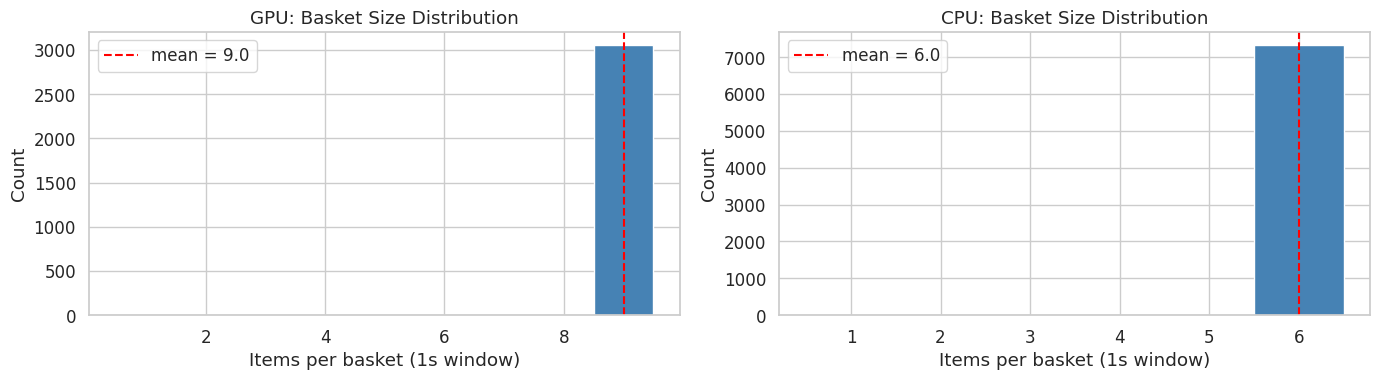

In [64]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=False)

for ax, (label, baskets) in zip(axes, [("GPU", gpu_baskets), ("CPU", cpu_baskets)]):
    sizes = [len(b) for b in baskets]
    ax.hist(sizes, bins=range(1, max(sizes) + 2), edgecolor="white", color="steelblue", align="left")
    ax.set_xlabel("Items per basket (1s window)")
    ax.set_ylabel("Count")
    ax.set_title(f"{label}: Basket Size Distribution")
    ax.axvline(np.mean(sizes), color="red", linestyle="--", label=f"mean = {np.mean(sizes):.1f}")
    ax.legend()
    print(f"{label} basket sizes: min={min(sizes)}, max={max(sizes)}, "f"mean={np.mean(sizes):.1f}, median={np.median(sizes):.0f}")

plt.tight_layout()
plt.show()

### 5.2 Frequency of top items

Now that baskets are constructed, the frequency of each symbolic item (e.g., 'gpu_util=HIGH') across all baskets is computed and visualized. This identifies which conditions are most common in the dataset, which may dominate the itemset mining results.

GPU: 25 unique items | >10% support: 21 | >1%: 25
CPU: 16 unique items | >10% support: 16 | >1%: 16


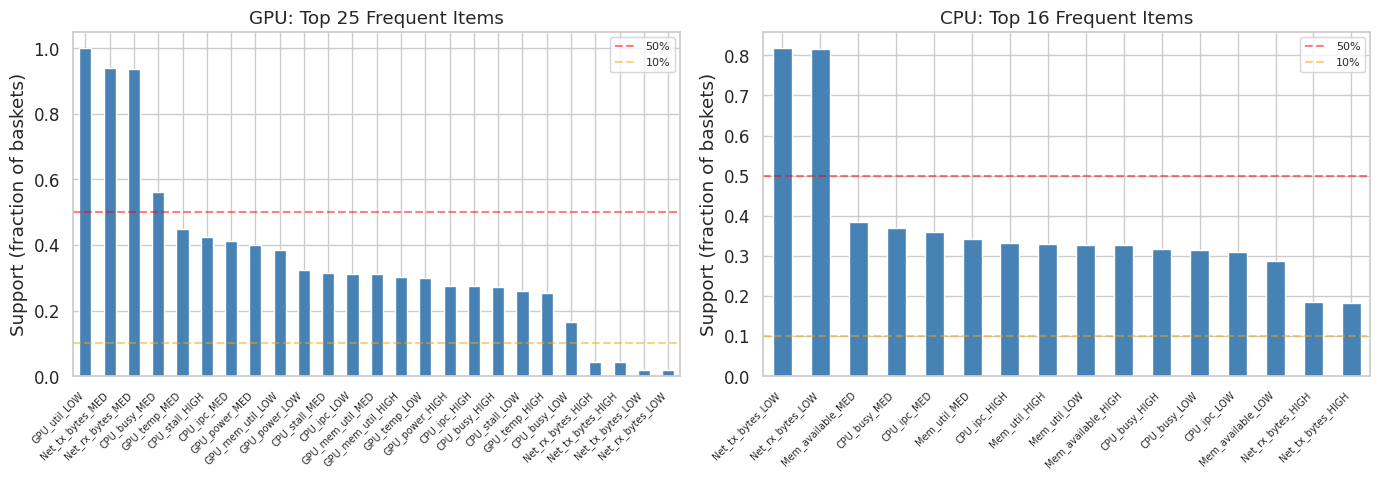

In [65]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

item_support_dict = {}

for ax, (label, baskets) in zip(axes, [("GPU", gpu_baskets), ("CPU", cpu_baskets)]):
    counts = Counter()
    for b in baskets:
        counts.update(b)
    freq = pd.Series(counts).sort_values(ascending=False)
    support = freq / len(baskets)
    item_support_dict[label] = support

    top_n = min(25, len(support))
    support.head(top_n).plot.bar(ax=ax, color="steelblue")
    ax.set_ylabel("Support (fraction of baskets)")
    ax.set_title(f"{label}: Top {top_n} Frequent Items")
    ax.axhline(0.5, color="red", linestyle="--", alpha=0.5, label="50%")
    ax.axhline(0.1, color="orange", linestyle="--", alpha=0.5, label="10%")
    ax.legend(fontsize=8)
    plt.sca(ax)
    plt.xticks(rotation=45, ha="right", fontsize=7)

    print(f"{label}: {len(freq)} unique items | "f">10% support: {(support > 0.1).sum()} | >1%: {(support > 0.01).sum()}")

plt.tight_layout()
plt.show()

### 5.3 Co-occurrence matrix sparsity

To assess the sparsity of the item co-occurrence matrix, the number of unique items and their pairwise co-occurrence counts across all baskets are computed. A heatmap of the co-occurrence matrix is visualized to identify dense vs. sparse regions, which has implications for the feasibility and interpretability of frequent itemset mining results.

GPU: 264/300 pairs nonzero, sparsity=12.0%
CPU: 106/120 pairs nonzero, sparsity=11.7%


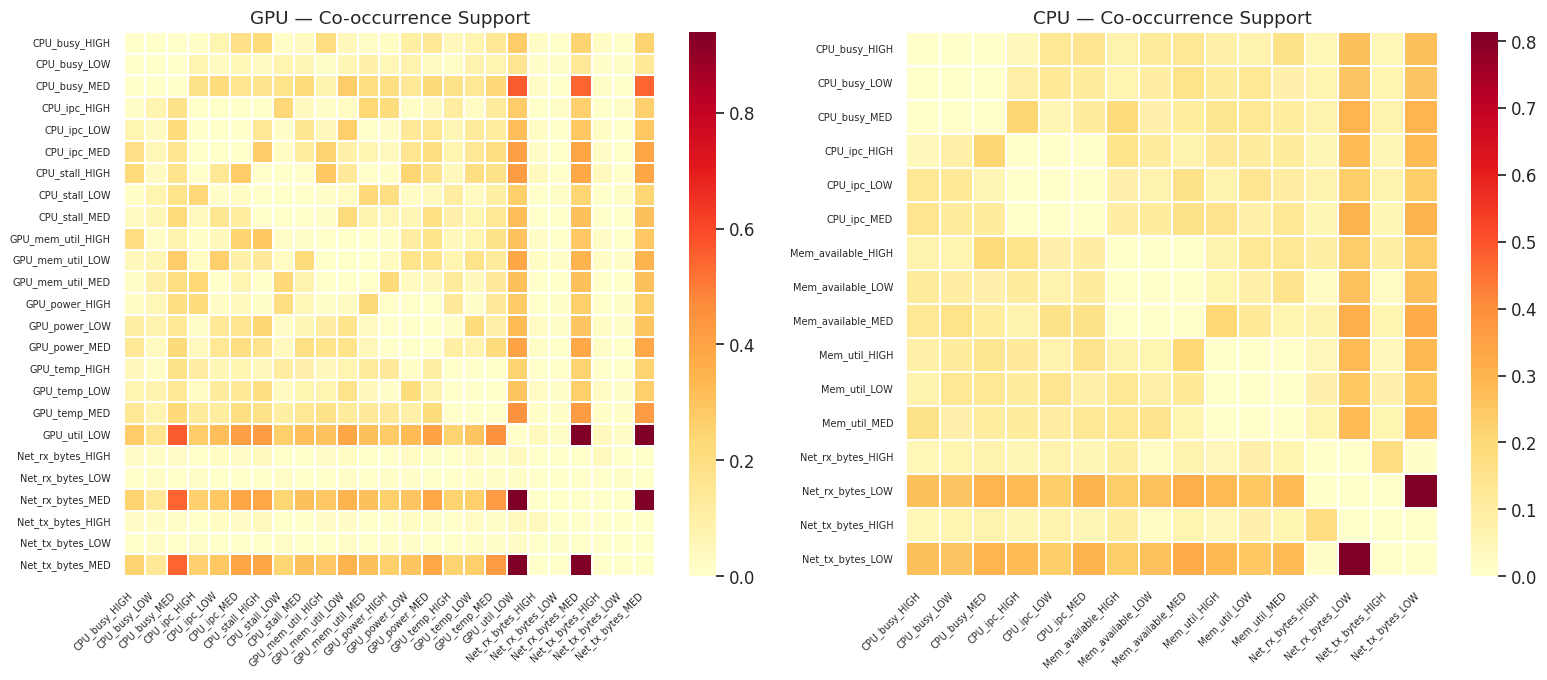

In [66]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

pair_counts_dict = {} # for feasibility check and sparsity calculation

for ax, (label, baskets) in zip(axes, [("GPU", gpu_baskets), ("CPU", cpu_baskets)]):
    support = item_support_dict[label]
    items_list = sorted(support.index)

    pc = Counter()
    for b in baskets:
        for pair in combinations(sorted(b), 2):
            pc[pair] += 1
    pair_counts_dict[label] = pc

    total_possible = len(items_list) * (len(items_list) - 1) // 2
    nonzero = len(pc)
    sparsity = 1 - (nonzero / total_possible) if total_possible > 0 else 0
    print(f"{label}: {nonzero}/{total_possible} pairs nonzero, sparsity={sparsity:.1%}")

    # Co-occurrence heatmap
    cooc = pd.DataFrame(0, index=items_list, columns=items_list, dtype=float)
    for (a, b), count in pc.items():
        cooc.loc[a, b] = count / len(baskets)
        cooc.loc[b, a] = count / len(baskets)

    sns.heatmap(cooc, cmap="YlOrRd", ax=ax, linewidths=0.3, xticklabels=True, yticklabels=True)
    ax.set_title(f"{label} — Co-occurrence Support")
    plt.sca(ax)
    plt.xticks(rotation=45, ha="right", fontsize=7)
    plt.yticks(fontsize=7)

plt.tight_layout()
plt.show()

### 5.4 Run lengths and temporal structure

The number of baskets per run is analyzed to understand the temporal structure of the data. Short runs with few baskets may produce less reliable itemsets, while long runs may dominate the results. The distribution of run lengths is visualized and summarized to inform windowing decisions in part 6.

GPU: min=1, max=808, median=18, mean=153 | <10 baskets: 8
CPU: min=2, max=2410, median=49, mean=366 | <10 baskets: 5


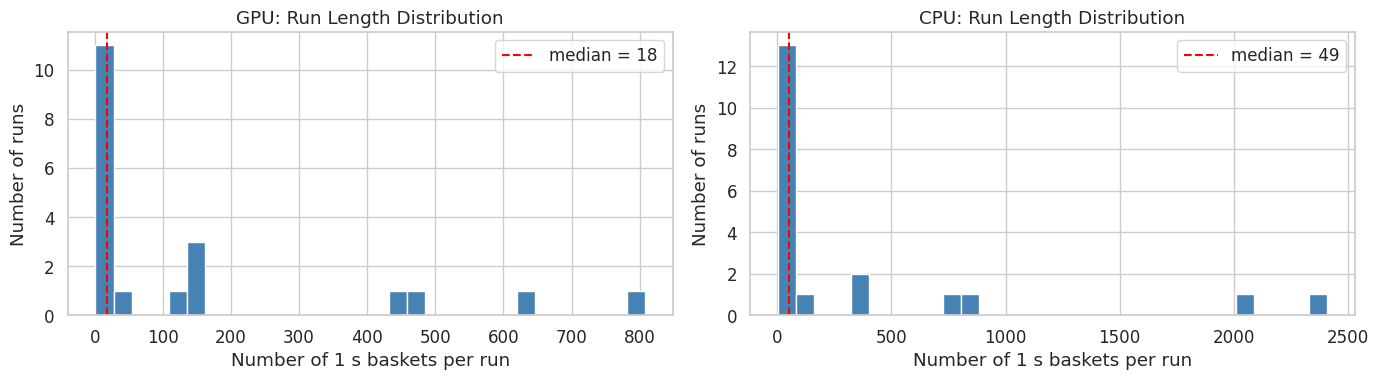

In [67]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

for ax, (label, bpf) in zip(axes, [("GPU", gpu_baskets_per_file), ("CPU", cpu_baskets_per_file)]):
    bc = pd.Series({n: len(b) for n, b in bpf.items()})
    ax.hist(bc.values, bins=30, color="steelblue", edgecolor="white")
    ax.set_xlabel("Number of 1 s baskets per run")
    ax.set_ylabel("Number of runs")
    ax.set_title(f"{label}: Run Length Distribution")
    ax.axvline(bc.median(), color="red", linestyle="--", label=f"median = {bc.median():.0f}")
    ax.legend()
    print(f"{label}: min={bc.min()}, max={bc.max()}, "f"median={bc.median():.0f}, mean={bc.mean():.0f} | "f"<10 baskets: {(bc < 10).sum()}")

plt.tight_layout()
plt.show()

### 5.5 Rule feasibility check

To verify that Apriori & FP-growth will be tractable, the number of frequent items and frequent pairs is computed at several support thresholds. If too many itemsets are frequent, it may indicate that the dataset is too dense for meaningful rule mining without further pruning or dimensionality reduction.

In [68]:
support_thresholds = [0.01, 0.005, 0.001]

results = []
for label, baskets in [("GPU", gpu_baskets), ("CPU", cpu_baskets)]:
    support = item_support_dict[label]
    pc = pair_counts_dict[label]
    pair_supp = {p: c / len(baskets) for p, c in pc.items()}
    for thresh in support_thresholds:
        results.append({
            "hw": label,
            "support_threshold": f"{thresh:.1%}",
            "frequent_items": (support >= thresh).sum(),
            "frequent_pairs": sum(1 for s in pair_supp.values() if s >= thresh),
        })

feasibility = pd.DataFrame(results)
print("Rule feasibility check:")
display(feasibility)

Rule feasibility check:


,hw,support_threshold,frequent_items,frequent_pairs
0,GPU,1.0%,25,225
1,GPU,0.5%,25,233
2,GPU,0.1%,25,251
3,CPU,1.0%,16,104
4,CPU,0.5%,16,104
5,CPU,0.1%,16,106


## 6. Window-Size Sensitivity

Different window lengths (1s, 2s, 5s) can change discovered patterns. To show that the choice of window length does not drastically alter the basket structure, the basket size distributions are compared across different window lengths.

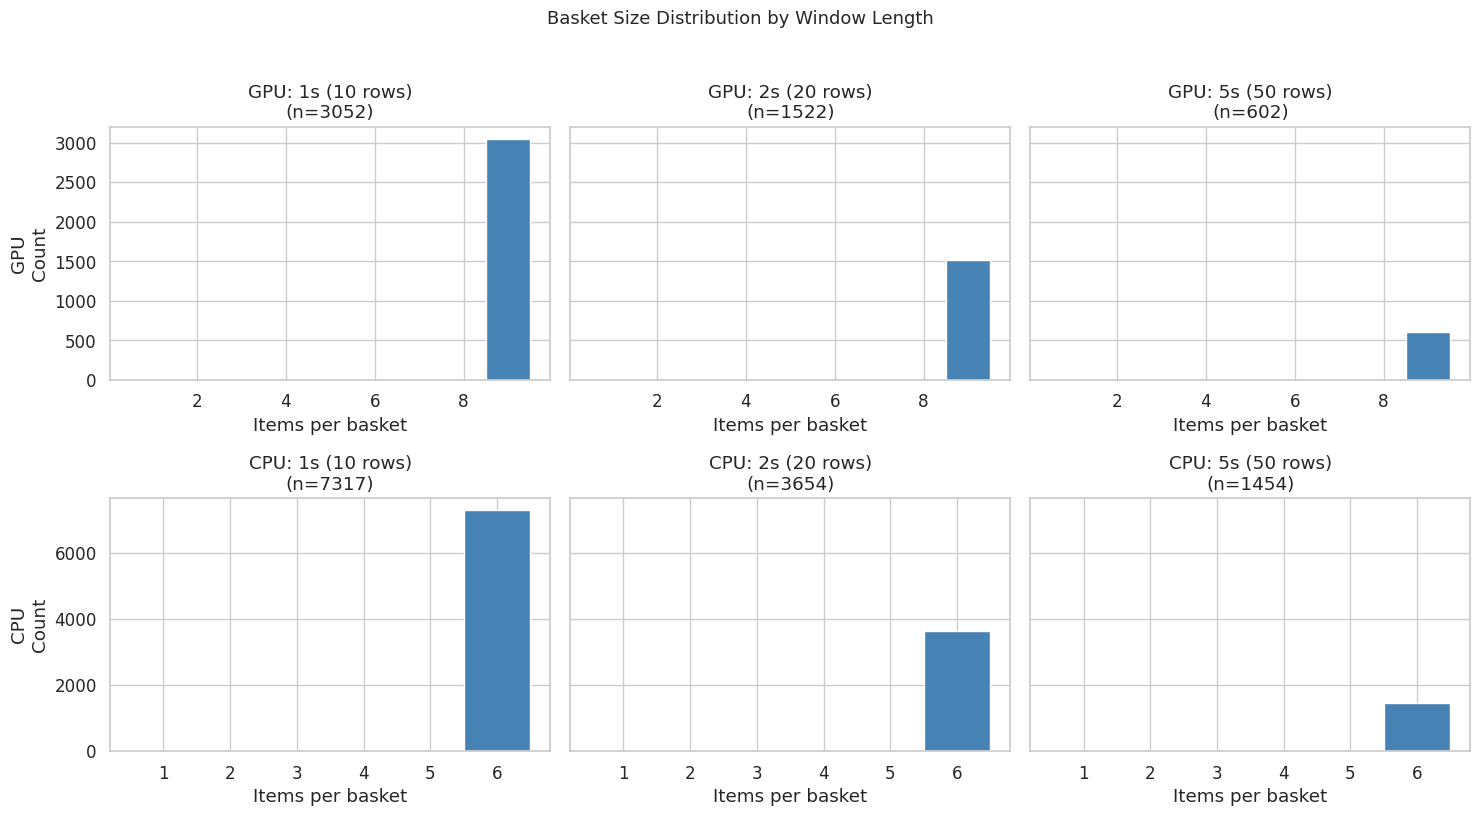

In [69]:
window_configs = {"1s (10 rows)": 10, "2s (20 rows)": 20, "5s (50 rows)": 50}

fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharey="row")

for row, (label, dfs, curated, thresholds) in enumerate([("GPU", sample_gpu_dfs, curated_gpu, thresholds_gpu), ("CPU", sample_cpu_dfs, curated_cpu, thresholds_cpu)]):
    for col, (wlabel, ws) in enumerate(window_configs.items()):
        ax = axes[row, col]
        baskets_ws = []
        for df in dfs.values():
            baskets_ws.extend(window_and_discretize(df, curated, thresholds, window_size=ws))
        sizes = [len(b) for b in baskets_ws]
        ax.hist(sizes, bins=range(1, max(sizes) + 2), edgecolor="white", color="steelblue", align="left")
        ax.set_title(f"{label}: {wlabel}\n(n={len(baskets_ws)})")
        ax.set_xlabel("Items per basket")
        if col == 0:
            ax.set_ylabel(f"{label}\nCount")

plt.suptitle("Basket Size Distribution by Window Length", fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

## 7. Validation Tests

Assertions to verify that the preprocessing and basket construction pipeline is correct.

In [70]:
for label, all_bask, bpf, dfs, curated, excluded, thresholds in [("GPU", gpu_baskets, gpu_baskets_per_file, sample_gpu_dfs, curated_gpu, excluded_gpu, thresholds_gpu), ("CPU", cpu_baskets, cpu_baskets_per_file, sample_cpu_dfs, curated_cpu, excluded_cpu, thresholds_cpu)]:
    print(f"\n{label} Validation")

    # Test 1: No basket has conflicting levels for the same metric group
    for i, b in enumerate(all_bask):
        groups_seen = set()
        for item in b:
            group = "_".join(item.split("_")[:-1])
            assert group not in groups_seen, (f"{label} basket {i} has duplicate group '{group}': {b}")
            groups_seen.add(group)
    print("Test 1: No conflicting levels for the same metric group")

    # Test 2: Basket count ≤ expected from row count
    for name, df in dfs.items():
        expected = len(df) // WINDOW_SIZE
        actual = len(bpf[name])
        assert actual <= expected, (f"{label} {name}: {actual} baskets but at most {expected} expected")
    print("Test 2: Basket counts consistent with row counts")

    # Test 3: Every item has a valid level suffix
    valid_levels = {"LOW", "MED", "HIGH"}
    for b in all_bask:
        for item in b:
            level = item.split("_")[-1]
            assert level in valid_levels, f"Invalid item: {item}"
    print("Test 3: All items have valid LOW/MED/HIGH suffixes")

    # Test 4: No excluded metrics in curated set
    curated_flat = set()
    for cols in curated.values():
        curated_flat.update(cols)
    overlap = curated_flat & excluded
    assert len(overlap) == 0, f"Excluded metrics in curated set: {overlap}"
    print("Test 4: No excluded metrics in curated set")

    # Test 5: Thresholds are monotonic (lo ≤ hi)
    for group, (lo, hi) in thresholds.items():
        assert lo <= hi, f"Non-monotonic: {group}: {lo} > {hi}"
    print("Test 5: All thresholds monotonic")

print("\nAll validation tests passed for both GPU and CPU")


GPU Validation
Test 1: No conflicting levels for the same metric group
Test 2: Basket counts consistent with row counts
Test 3: All items have valid LOW/MED/HIGH suffixes
Test 4: No excluded metrics in curated set
Test 5: All thresholds monotonic

CPU Validation
Test 1: No conflicting levels for the same metric group
Test 2: Basket counts consistent with row counts
Test 3: All items have valid LOW/MED/HIGH suffixes
Test 4: No excluded metrics in curated set
Test 5: All thresholds monotonic

All validation tests passed for both GPU and CPU


## 8. Collaboration Declaration

1. Collaborators: 
- None.
2. Web sources:
- Hugging Face dataset card: https://huggingface.co/datasets/subsetchen/RevealTelemetryDatasetforMLInfraProfilingAnomalyDetection
- Reveal paper: https://arxiv.org/abs/2510.26008
3. AI tools:
- I used ChatGPT to help plan the notebook structure. Specifically, I gave it my project description and dataset overview and asked it to generate a detailed outline for an EDA notebook covering data inventory, quality assessment, cleaning decisions, and symbolic basket construction. The outline it produced was well-organized and I used it as the skeleton for this notebook, filling in the actual code and analysis myself.
4. Citations:
- Chen, Z., Chien, S. W. D., Qian, P., & Zilberman, N. (2025). *Detecting Anomalies in Machine Learning Infrastructure via Hardware Telemetry*. arXiv:2510.26008.